# Compare methods with optimize parameters in ref_case

In [3]:
import xarray as xr
import pandas as pd
import numpy as np

import hvplot.xarray
import hvplot.pandas

import matplotlib.pyplot as plt
from cycler import cycler

from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

import hvplot.xarray
import hvplot.pandas
import holoviews as hv

import pynsitu as pyn
import lib as lib
from lib import KEYS, raw_dir, images_dir
import os
from glob import glob

import synthetic_traj as st

from synthetic_traj import (
    synthetic_traj,
    noise_irregular_sampling,
    ref_case,
    typical_case,
)

In [4]:
def ms_diff(DF, true_key, var=["x", "y", "u", "v", "ax", "ay", "X", "U", "Axy"]):
    DF = DF.copy()
    dft = DF[true_key]
    dft_ = (dft.set_index("id")[var]).groupby("id").var()
    dfms = pd.DataFrame(index=DF.keys(), columns=var)
    dfmsr = pd.DataFrame(index=DF.keys(), columns=var)
    for l in DF:
        df = DF[l]
        if np.all(df.index.values == dft.index.values):
            df_ = df.set_index("id")[var] - dft.set_index("id")[var]
            # dfr_ = (df.set_index('id')[var]-dft.set_index('id')[var])/dft.set_index('id')[var]
            dfms.loc[l] = df_.groupby("id").var().mean()
            dfmsr.loc[l] = (df_.groupby("id").var() / dft_).mean()
        else:
            print(l + " has not the same time index")
            continue
    dfms = pd.concat(
        [dfms, dfmsr.rename(columns={v: "ratio_" + v for v in var})], axis=1
    ).dropna()
    return dfms

___________
# Reference case + centered_diff

In [5]:
N = 100
acc_cut = 1e-3
position_noise = 20
ntype = "white_noise"
offset_type = "svp_scripps_10"
dt_smooth = "30min"
true_key = "True_" + dt_smooth
spectral_diff = False
ref_case["spectral_diff"] = spectral_diff
print(ref_case)

{'T': 5, 'U_low': 0.3, 'U_ni': 0.2, 'U_2': 0, 'U_1': 0, 'tau_eta': 0.1, 'n_layers': 5, 'spectral_diff': False}


In [6]:
DF = dict()

# TRUE
t = (
    50,
    "1min",
)  # use it instead of (50, 1/24/60 because otherwise not regularly sampled
dst = synthetic_traj(t, N, **ref_case)  # u,v, ax, ay computed
dft = st.dataset2dataframe(dst).rename(columns={"draw": "id"})
DF["True_1min"] = dft

# OBSERVED
dso = noise_irregular_sampling(
    dst, t, position_noise, ntype=ntype, offset_type=offset_type, istart=6097
)
dfo = st.dataset2dataframe(dso).rename(columns={"draw": "id"})
dfo = dfo.groupby("id").apply(pyn.geo.compute_dt, time="index")


DF["Observed"] = dfo

# Interpolated True
dsti = dst.sel(time=pd.date_range(dfo.index.min(), dfo.index.max(), freq=dt_smooth))
dsti["dt"] = dsti.time.diff("time") / pd.Timedelta("1s")
st.add_position_noise(
    dsti, dsti.time, position_noise, ntype=ntype, inplace=True
)  # adding noise
dsti["u_noise"] = dsti.x_noise.differentiate("time", datetime_unit="s")
dsti["v_noise"] = dsti.y_noise.differentiate("time", datetime_unit="s")
dfti = st.dataset2dataframe(dsti).rename(columns={"draw": "id"})
dfti = dfti.groupby("id").apply(
    pyn.geo.compute_velocities,
    time="index",
    distance="xy",
    names=("u", "v", "U"),
    fill_startend=True,
    centered=True,
    keep_dt=True,
)
dfti = dfti.groupby("id").apply(
    pyn.geo.compute_accelerations,
    from_=("xy", "x", "y"),
    names=("ax", "ay", "Axy"),
    keep_dt=True,
)
dfti = dfti.groupby("id").apply(
    pyn.geo.compute_accelerations,
    from_=("xy", "x_noise", "y_noise"),
    names=("ax_noise", "ay_noise", "Axy_noise"),
    keep_dt=True,
)
dsti = dfti.reset_index().set_index(["time", "id"]).to_xarray()

DF["True_" + dt_smooth] = dfti

centred diff
centred diff
-13394.13809599266
6097


In [7]:
parameters_var = dict(
    acc_cut=1,
    position_error=60,
    acceleration_amplitude=4e-6,
    acceleration_T=0.05 * 86400,
    time_chunk=2,
    acc_cut_key=("ax", "ay", "Axy"),
)
parameters_lowess = dict(degree=2, iteration=3, T_low_pass = 10, cutoff_low_pass = 13)
parameters_spydell = dict(nb_pt_mean=5, acc_cut=1)


dfl = pyn.drifters.smooth_all(
    dfo,
    "lowess",
    dt_smooth,
    parameters=parameters_lowess,
    spectral_diff=spectral_diff,
    geo=False,
)
dfv = pyn.drifters.smooth_all(
    dfo,
    "variational",
    dt_smooth,
    parameters=parameters_var,
    spectral_diff=spectral_diff,
    geo=False,
)
dfs = pyn.drifters.smooth_all(
    dfo,
    "spydell",
    dt_smooth,
    parameters=parameters_spydell,
    spectral_diff=spectral_diff,
    geo=False,
)

DF["LOWESS"] = dfl
DF["Variational"] = dfv
DF["Empirical"] = dfs
color = {
    "True_1min": "grey",
    "Observed": "gold",
    "True_30min": "k",
    "LOWESS": "teal",
    "Variational": "salmon",
    "Empirical": "r",
}

LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd with 10pad
LOW-PASS : 13cpd wit

In [23]:
dfl

u         v              x              y  \
time                                                                    
2000-01-01 00:10:00  0.025424 -0.182371      -3.144140    -192.626831   
2000-01-01 00:40:00  0.026362 -0.185151      43.463205    -523.397149   
2000-01-01 01:10:00  0.025256 -0.179080      89.919470    -851.204983   
2000-01-01 01:40:00  0.026703 -0.162176     136.683179   -1158.335360   
2000-01-01 02:10:00  0.034443 -0.139979     191.714937   -1430.275373   
...                       ...       ...            ...            ...   
2000-02-19 21:40:00  0.052869  0.267102  104924.601145 -193952.303982   
2000-02-19 22:10:00  0.026723  0.281597  104996.234262 -193458.474803   
2000-02-19 22:40:00  0.014515  0.294806  105033.349014 -192939.711815   
2000-02-19 23:10:00  0.012976  0.299992  105058.091428 -192404.393579   
2000-02-19 23:40:00  0.013960  0.297680  105082.334272 -191866.489403   

                               ax            ay           Axy      dt  \
time                                                                    
2000-01-01 00:10:00 -4.663003e-08  9.143472e-07  9.155355e-07  1800.0   
2000-01-01 00:40:00 -4.663003e-08  9.143472e-07  9.155355e-07  1800.0   
2000-01-01 01:10:00  9.489038e-08  6.381931e-06  6.382637e-06  1800.0   
2000-01-01 01:40:00  2.551867e-06  1.086122e-05  1.115698e-05  1800.0   
2000-01-01 02:10:00  4.983304e-06  1.201229e-05  1.300494e-05  1800.0   
...                           ...           ...           ...     ...   
2000-02-19 21:40:00 -1.614326e-05  6.740159e-06  1.749385e-05  1800.0   
2000-02-19 22:10:00 -1.065382e-05  7.695620e-06  1.314254e-05  1800.0   
2000-02-19 22:40:00 -3.818623e-06  5.109644e-06  6.378898e-06  1800.0   
2000-02-19 23:10:00 -1.541883e-07  7.981296e-07  8.128868e-07  1800.0   
2000-02-19 23:40:00 -1.541883e-07  7.981296e-07  8.128868e-07  1800.0   

                               au            av           Auv              X  \
time                                                                           
2000-01-01 00:10:00 -4.663003e-08  9.143472e-07  9.155355e-07     192.652489   
2000-01-01 00:40:00 -4.663003e-08  9.143472e-07  9.155355e-07     525.198654   
2000-01-01 01:10:00  9.489038e-08  6.381931e-06  6.382637e-06     855.941257   
2000-01-01 01:40:00  2.551867e-06  1.086122e-05  1.115698e-05    1166.371767   
2000-01-01 02:10:00  4.983304e-06  1.201229e-05  1.300494e-05    1443.066963   
...                           ...           ...           ...            ...   
2000-02-19 21:40:00 -1.614326e-05  6.740159e-06  1.749385e-05  220514.553138   
2000-02-19 22:10:00 -1.065382e-05  7.695620e-06  1.314254e-05  220114.494485   
2000-02-19 22:40:00 -3.818623e-06  5.109644e-06  6.378898e-06  219676.436607   
2000-02-19 23:10:00 -1.541883e-07  7.981296e-07  8.128868e-07  219218.277620   
2000-02-19 23:40:00 -1.541883e-07  7.981296e-07  8.128868e-07  218757.963813   

                            U  gap_mask  gaps  id  
time                                               
2000-01-01 00:10:00  0.184135         0   0.0   0  
2000-01-01 00:40:00  0.187019         0   0.0   0  
2000-01-01 01:10:00  0.180852         0   0.0   0  
2000-01-01 01:40:00  0.164360         0   0.0   0  
2000-01-01 02:10:00  0.144155         0   0.0   0  
...                       ...       ...   ...  ..  
2000-02-19 21:40:00  0.272284         0   0.0  99  
2000-02-19 22:10:00  0.282862         0   0.0  99  
2000-02-19 22:40:00  0.295163         0   0.0  99  
2000-02-19 23:10:00  0.300272         0   0.0  99  
2000-02-19 23:40:00  0.298007         0   0.0  99  

[240000 rows x 16 columns]

___________
# HVPLOT

In [8]:
def hvplot_DF(DF, d, var=None):
    if not var:
        var = ["x", "y", "u", "v", "ax", "ay"]
    Hv = []
    for v in var:
        init = 0
        for l in DF:
            df = DF[l]
            if init == 0:
                hvplot = df[df.id == d][v].hvplot(
                    label=l, kind="scatter", color=color[l]
                )
                init = 1
            hvplot *= df[df.id == d][v].hvplot(label=l, kind="scatter", color=color[l])
        Hv.append(hvplot)
    print(len(Hv))
    layout = hv.Layout(Hv[0] + Hv[1] + Hv[2] + Hv[3] + Hv[4] + Hv[5]).cols(2)
    return layout

In [9]:
d = 0
DF0 = DF.copy()
DF0.pop("True_1min")
hvplot_DF(DF0, d, ["x", "y", "u", "v", "ax", "ay"])

6


:Layout
   .Overlay.I   :Overlay
      .Scatter.Observed.I  :Scatter   [time]   (x)
      .Scatter.Observed.II :Scatter   [time]   (x)
      .Scatter.True_30min  :Scatter   [time]   (x)
      .Scatter.LOWESS      :Scatter   [time]   (x)
      .Scatter.Variational :Scatter   [time]   (x)
      .Scatter.Empirical   :Scatter   [time]   (x)
   .Overlay.II  :Overlay
      .Scatter.Observed.I  :Scatter   [time]   (y)
      .Scatter.Observed.II :Scatter   [time]   (y)
      .Scatter.True_30min  :Scatter   [time]   (y)
      .Scatter.LOWESS      :Scatter   [time]   (y)
      .Scatter.Variational :Scatter   [time]   (y)
      .Scatter.Empirical   :Scatter   [time]   (y)
   .Overlay.III :Overlay
      .Scatter.Observed.I  :Scatter   [time]   (u)
      .Scatter.Observed.II :Scatter   [time]   (u)
      .Scatter.True_30min  :Scatter   [time]   (u)
      .Scatter.LOWESS      :Scatter   [time]   (u)
      .Scatter.Variational :Scatter   [time]   (u)
      .Scatter.Empirical   :Scatter   [time]   (u)
   .Overlay.IV  :Overlay
      .Scatter.Observed.I  :Scatter   [time]   (v)
      .Scatter.Observed.II :Scatter   [time]   (v)
      .Scatter.True_30min  :Scatter   [time]   (v)
      .Scatter.LOWESS      :Scatter   [time]   (v)
      .Scatter.Variational :Scatter   [time]   (v)
      .Scatter.Empirical   :Scatter   [time]   (v)
   .Overlay.V   :Overlay
      .Scatter.Observed.I  :Scatter   [time]   (ax)
      .Scatter.Observed.II :Scatter   [time]   (ax)
      .Scatter.True_30min  :Scatter   [time]   (ax)
      .Scatter.LOWESS      :Scatter   [time]   (ax)
      .Scatter.Variational :Scatter   [time]   (ax)
      .Scatter.Empirical   :Scatter   [time]   (ax)
   .Overlay.VI  :Overlay
      .Scatter.Observed.I  :Scatter   [time]   (ay)
      .Scatter.Observed.II :Scatter   [time]   (ay)
      .Scatter.True_30min  :Scatter   [time]   (ay)
      .Scatter.LOWESS      :Scatter   [time]   (ay)
      .Scatter.Variational :Scatter   [time]   (ay)
      .Scatter.Empirical   :Scatter   [time]   (ay)

In [10]:
DF_diff = st.build_DF_diff(DF0, true_key="True_30min")

Observed has not the same time index


In [11]:
d = 0
hvplot_DF(DF_diff, d, ["x", "y", "u", "v", "ax", "ay"])

6


:Layout
   .Overlay.I   :Overlay
      .Scatter.LOWESS.I    :Scatter   [time]   (x)
      .Scatter.LOWESS.II   :Scatter   [time]   (x)
      .Scatter.Variational :Scatter   [time]   (x)
      .Scatter.Empirical   :Scatter   [time]   (x)
   .Overlay.II  :Overlay
      .Scatter.LOWESS.I    :Scatter   [time]   (y)
      .Scatter.LOWESS.II   :Scatter   [time]   (y)
      .Scatter.Variational :Scatter   [time]   (y)
      .Scatter.Empirical   :Scatter   [time]   (y)
   .Overlay.III :Overlay
      .Scatter.LOWESS.I    :Scatter   [time]   (u)
      .Scatter.LOWESS.II   :Scatter   [time]   (u)
      .Scatter.Variational :Scatter   [time]   (u)
      .Scatter.Empirical   :Scatter   [time]   (u)
   .Overlay.IV  :Overlay
      .Scatter.LOWESS.I    :Scatter   [time]   (v)
      .Scatter.LOWESS.II   :Scatter   [time]   (v)
      .Scatter.Variational :Scatter   [time]   (v)
      .Scatter.Empirical   :Scatter   [time]   (v)
   .Overlay.V   :Overlay
      .Scatter.LOWESS.I    :Scatter   [time]   (ax)
      .Scatter.LOWESS.II   :Scatter   [time]   (ax)
      .Scatter.Variational :Scatter   [time]   (ax)
      .Scatter.Empirical   :Scatter   [time]   (ax)
   .Overlay.VI  :Overlay
      .Scatter.LOWESS.I    :Scatter   [time]   (ay)
      .Scatter.LOWESS.II   :Scatter   [time]   (ay)
      .Scatter.Variational :Scatter   [time]   (ay)
      .Scatter.Empirical   :Scatter   [time]   (ay)

___________
# MS

In [12]:
dfms = ms_diff(DF, true_key="True_" + dt_smooth).astype(float)
dfr = dfms[[l for l in dfms.columns if "ratio_" in l]]
dfr = dfr.rename(columns={l: l.replace("ratio_", "") for l in dfr.columns}) * 100

True_1min has not the same time index
Observed has not the same time index


In [13]:
dfms

x              y         u         v            ax  \
True_30min        0.000000       0.000000  0.000000  0.000000  0.000000e+00   
LOWESS         1899.641178    1859.991964  0.000021  0.000020  1.922400e-11   
Variational   37904.859120   37971.003900  0.000149  0.000150  3.001490e-11   
Empirical    768140.837313  883557.190386  0.000166  0.000166  7.362937e-11   

                       ay              X         U           Axy  \
True_30min   0.000000e+00       0.000000  0.000000  0.000000e+00   
LOWESS       1.923324e-11    1798.071236  0.000020  1.859096e-11   
Variational  3.010990e-11   39101.723663  0.000172  2.678053e-11   
Empirical    7.188306e-11  778446.480677  0.000163  8.880672e-11   

                  ratio_x       ratio_y   ratio_u   ratio_v  ratio_ax  \
True_30min   0.000000e+00  0.000000e+00  0.000000  0.000000  0.000000   
LOWESS       7.031119e-08  7.310358e-08  0.000187  0.000183  0.073230   
Variational  1.475340e-06  1.444557e-06  0.001358  0.001363  0.114336   
Empirical    2.880957e-05  3.686291e-05  0.001512  0.001510  0.281546   

             ratio_ay       ratio_X   ratio_U  ratio_Axy  
True_30min   0.000000  0.000000e+00  0.000000   0.000000  
LOWESS       0.073322  4.657673e-08  0.000379   0.180691  
Variational  0.114762  1.072109e-06  0.003270   0.260258  
Empirical    0.274662  2.127992e-05  0.003158   0.862807

In [14]:
dfr = dfr.iloc[1:]

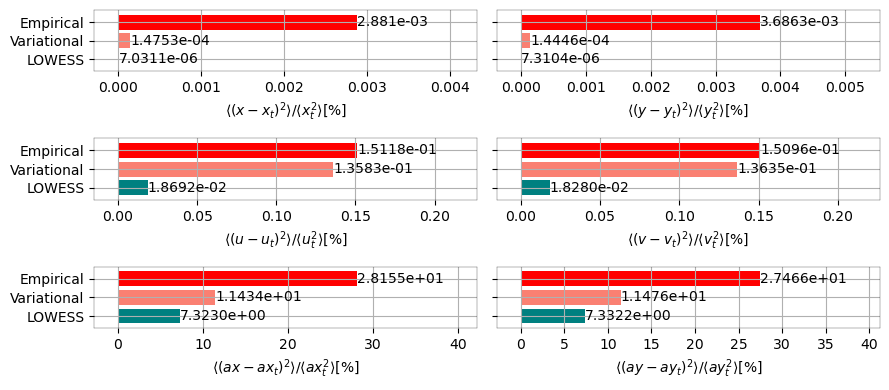

In [20]:
fig, axs = plt.subplots(3, 2, sharey=True, figsize=(9, 4))
i = 0
axs = axs.flatten()
for var in [
    "x",
    "y",
    "u",
    "v",
    "ax",
    "ay",
]:
    ax = axs[i]
    dfr[var].plot.barh(ax=ax, color=["teal", "salmon", "r"], width=0.8)
    ax.grid()
    ax.set_xlim(-0.1 * dfr[var].max(), dfr[var].max() * 1.5)
    i += 1
    ax.set_xlabel(
        rf"$\langle ({var}-{var}_t)^2 \rangle / \langle {var}_t^2 \rangle [\%]$"
    )
    ax.bar_label(
        ax.containers[0],
        labels=[
            np.format_float_scientific(l, precision=4, exp_digits=2)
            for l in dfr[var].values
        ],
    )
fig.tight_layout()
# fig.suptitle('refcase =' +str(ref_case) + '\n spydell ' +str(parameters_spydell)+'\n variational '+str(parameters_var)+'\n lowess '+str(parameters_lowess),
#            x= 0.5, y=-0.02, fontsize=8)
path = os.path.join(images_dir, "comp_method_ref_case.png")
fig.savefig(path, dpi=250)

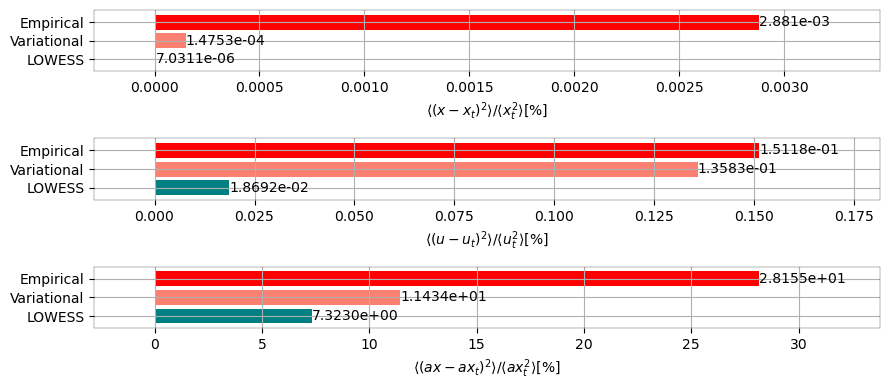

In [19]:
fig, axs = plt.subplots(3, 1, sharey=True, figsize=(9, 4))
i = 0
axs = axs.flatten()
for var in [
    "x",
    "u",
    "ax",
]:
    ax = axs[i]
    dfr[var].plot.barh(ax=ax, color=["teal", "salmon", "r"], width=0.8)
    ax.grid()
    ax.set_xlim(-0.1 * dfr[var].max(), dfr[var].max() * 1.2)
    i += 1
    ax.set_xlabel(
        rf"$\langle ({var}-{var}_t)^2 \rangle / \langle {var}_t^2 \rangle [\%]$"
    )
    ax.bar_label(
        ax.containers[0],
        labels=[
            np.format_float_scientific(l, precision=4, exp_digits=2)
            for l in dfr[var].values
        ],
    )
fig.tight_layout()
# fig.suptitle('refcase =' +str(ref_case) + '\n spydell ' +str(parameters_spydell)+'\n variational '+str(parameters_var)+'\n lowess '+str(parameters_lowess),
#            x= 0.5, y=-0.02, fontsize=8)
path = os.path.join(images_dir, "comp_method_ref_case.png")
fig.savefig(path, dpi=250)